<b>AML2019</b>

<h3>Challenge 1</h3>
<h1>House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>22<sup>th</sup> March 2019</i>

The first AML challenge for this year is adapted from the well-known '<i>Zillow's Home Value Prediction</i>' competition on Kaggle.
In particular, given a dataset containing descriptions of homes on the US property market, your task is to make predictions on the selling price of as-yet unlisted properties. 
Developing a model which accurately fits the available training data while also generalising to unseen data-points is a multi-faceted challenge that involves a mixture of data exploration, pre-processing, model selection, and performance evaluation.

# Overview
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Beyond simply producing a well-performing model for making predictions, in this challenge we would like you to start developing your skills as a machine learning scientist.
In this regard, your notebook should be structured in such a way as to explore the five following tasks that are expected to be carried out whenever undertaking such a project.
The description below each aspect should serve as a guide for your work, but you are strongly encouraged to also explore alternative options and directions. 
Thinking outside the box will always be rewarded in these challenges.

<div class="">
    <h3>1. Data Exploration</h3>
</div>

The first broad component of your notebook should enable you to familiarise yourselves with the given data, an outline of which is given at the end of this challenge specification.
Among others, this section should investigate:

- Data cleaning, e.g. treatment of categorial variables;
- Data visualisation;
- Computing descriptive statistics, e.g. correlation.
- etc.

<div class="">
    <h3>2. Data Pre-processing</h3>
</div>

The previous step should give you a better understanding of which pre-processing is required for the data.
This may include:

- Normalising and standardising the given data;
- Removing outliers;
- Carrying out feature selection, possibly using metrics derived from information theory;
- Handling missing information in the dataset;
- Augmenting the dataset with external information;
- Combining existing features.

<div class="">
    <h3>3. Model Selection</h3>
</div>

Perhaps the most important segment of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions.
Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models.
There is a wealth of models to choose from, such as <i>decision trees</i>, <i>random forests</i>, <i>(Bayesian) neural networks</i>, <i>Gaussian processes</i>, <i>LASSO regression</i>, and so on.
There are several factors which may influence your decision:

- What is the model's complexity?
- Is the model interpretable?
- Is the model capable of handling different data-types?
- Does the model return uncertainty estimates along with predictions?

An in-depth evaluation of competing models in view of this and other criteria will elevate the quality of your submission and earn you a higher grade.


<div class="">
    <h3>4. Parameter Optimisation</h3>
</div>

Irrespective of your choice, it is highly likely that your model will have one or more parameters that require tuning.
There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others.
As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

<div class="">
    <h3>5. Model Evaluation</h3>
</div>

Some form of pre-evaluation will inevitably be required in the preceding sections in order to both select an appropriate model and configure its parameters appropriately.
In this final section, you may evaluate other aspects of the model such as:

- Assessing the running time of your model;
- Determining whether some aspects can be parallelised;
- Training the model with smaller subsets of the data.
- etc.

<div class="alert alert-danger">
    <b>N.B.</b> Please note that the items listed under each heading are neither exhaustive, nor are you expected to explore every given suggestion.
    Nonetheless, these should serve as a guideline for your work in both this and upcoming challenges.
    As always, you should use your intuition and understanding in order to decide which analysis best suits the assigned task.
</div>

<div class="">
    <h2>Submission Instructions</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

- The goal of this challenge is to construct a model for predicting house prices;
<br><br>

- Your submission will have two components:

    1. An <b>HTML version of your notebook</b> exploring the various modelling aspects described above;
    2. A CSV file containing your <b>final model's predictions on the given test data</b>. 
       This file should contain a header and have the following format:
       
        ```
        Id,SalePrice
        1461,169000.1
        1462,187724.1233
        1463,175221
        etc.
        ```
        
        An example submission file has been provided in the data directory of the repository.
        A leaderboard for this challenge will be ranked using the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sales price. 
        Taking logs ensures that errors in predicting expensive houses and cheap houses will have a similar impact on the overall result;
<br><br>
- This exercise is due on <b>04/04/2019</b>.

<div class="">
    <h2>Dataset Description</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;"/>    
</div>

#### * Files

* train.csv - The training dataset;
* test.csv - The test dataset;
* data_description.txt - Full description of each column.

#### * Attributes

A brief outline of the available attributes is given below:

* <i>SalePrice</i>: The property's sale price in dollars. This is the target variable that your model is intended to predict;

* <i>MSSubClass</i>: The building class;
* <i>MSZoning</i>: The general zoning classification;
* <i>LotFrontage</i>: Linear feet of street connected to property;
* <i>LotArea</i>: Lot size in square feet;
* <i>Street</i>: Type of road access;
* <i>Alley</i>: Type of alley access;
* <i>LotShape</i>: General shape of property;
* <i>LandContour</i>: Flatness of the property;
* <i>Utilities</i>: Type of utilities available;
* <i>LotConfig</i>: Lot configuration;
* <i>LandSlope</i>: Slope of property;
* <i>Neighborhood</i>: Physical locations within Ames city limits;
* <i>Condition1</i>: Proximity to main road or railroad;
* <i>Condition2</i>: Proximity to main road or railroad (if a second is present);
* <i>BldgType</i>: Type of dwelling;
* <i>HouseStyle</i>: Style of dwelling;
* <i>OverallQual</i>: Overall material and finish quality;
* <i>OverallCond</i>: Overall condition rating;
* <i>YearBuilt</i>: Original construction date;
* <i>YearRemodAdd</i>: Remodel date;
* <i>RoofStyle</i>: Type of roof;
* <i>RoofMatl</i>: Roof material;
* <i>Exterior1st</i>: Exterior covering on house;
* <i>Exterior2nd</i>: Exterior covering on house (if more than one material);
* <i>MasVnrType</i>: Masonry veneer type;
* <i>MasVnrArea</i>: Masonry veneer area in square feet;
* <i>ExterQualv</i>: Exterior material quality;
* <i>ExterCond</i>: Present condition of the material on the exterior;
* <i>Foundation</i>: Type of foundation;
* <i>BsmtQual</i>: Height of the basement;
* <i>BsmtCond</i>: General condition of the basement;
* <i>BsmtExposure</i>: Walkout or garden level basement walls;
* <i>BsmtFinType1</i>: Quality of basement finished area;
* <i>BsmtFinSF1</i>: Type 1 finished square feet;
* <i>BsmtFinType2</i>: Quality of second finished area (if present);
* <i>BsmtFinSF2</i>: Type 2 finished square feet;
* <i>BsmtUnfSF</i>: Unfinished square feet of basement area;
* <i>TotalBsmtSF</i>: Total square feet of basement area;
* <i>Heating</i>: Type of heating;
* <i>HeatingQC</i>: Heating quality and condition;
* <i>CentralAir</i>: Central air conditioning;
* <i>Electrical</i>: Electrical system;
* <i>1stFlrSF</i>: First Floor square feet;
* <i>2ndFlrSF</i>: Second floor square feet;
* <i>LowQualFinSF</i>: Low quality finished square feet (all floors);
* <i>GrLivArea</i>: Above grade (ground) living area square feet;
* <i>BsmtFullBath</i>: Basement full bathrooms;
* <i>BsmtHalfBath</i>: Basement half bathrooms;
* <i>FullBath</i>: Full bathrooms above grade;
* <i>HalfBath</i>: Half baths above grade;
* <i>Bedroom</i>: Number of bedrooms above basement level;
* <i>Kitchen</i>: Number of kitchens;
* <i>KitchenQual</i>: Kitchen quality;
* <i>TotRmsAbvGrd</i>: Total rooms above grade (does not include bathrooms);
* <i>Functional</i>: Home functionality rating;
* <i>Fireplaces</i>: Number of fireplaces;
* <i>FireplaceQu</i>: Fireplace quality;
* <i>GarageType</i>: Garage location;
* <i>GarageYrBlt</i>: Year garage was built;
* <i>GarageFinish</i>: Interior finish of the garage;
* <i>GarageCars</i>: Size of garage in car capacity;
* <i>GarageArea</i>: Size of garage in square feet;
* <i>GarageQual</i>: Garage quality;
* <i>GarageCond</i>: Garage condition;
* <i>PavedDrive</i>: Paved driveway;
* <i>WoodDeckSF</i>: Wood deck area in square feet;
* <i>OpenPorchSF</i>: Open porch area in square feet;
* <i>EnclosedPorch</i>: Enclosed porch area in square feet;
* <i>3SsnPorch</i>: Three season porch area in square feet;
* <i>ScreenPorch</i>: Screen porch area in square feet;
* <i>PoolArea</i>: Pool area in square feet;
* <i>PoolQC</i>: Pool quality;
* <i>Fence</i>: Fence quality;
* <i>MiscFeature</i>: Miscellaneous feature not covered in other categories;
* <i>MiscVal</i>: Value (in dollars) of miscellaneous feature;
* <i>MoSold</i>: Month sold;
* <i>YrSold</i>: Year sold;
* <i>SaleType</i>: Type of sale;
* <i>SaleCondition</i>: Condition of sale.


### Useful links

- [Lin reg on Boston Housing dataset](https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155)
- [Lin reg in sckit learn](https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/)
- [Train test split and cross validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
- [Ridge and Lasso regression](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b)
- [Best article in Boston House Pricing](https://gogul09.github.io/software/regression-example-boston-housing-prices)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import seaborn as sns # plotting
from matplotlib import pyplot as plt # plots 

from sklearn.metrics import mean_squared_error


In [16]:
traindataset = pd.read_csv("challenge_data/train.csv")
realtraindataset = pd.read_csv("clean_train_data.csv")

print("Rows in dataset: ", traindataset.shape[0])
print("Colums in dataset: ",traindataset.shape[1])
#traindataset.head()

print("Rows in dataset: ", realtraindataset.shape[0])
print("Colums in dataset: ", realtraindataset.shape[1])
realtraindataset.head()


Rows in dataset:  1200
Colums in dataset:  81
Rows in dataset:  1200
Colums in dataset:  253


,Unnamed: 0,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
0,0,1,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,1,0,0,0,0,0
1,1,2,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,1,0,0,0,0,0
2,2,3,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,1,0,0,0,0,0
3,3,4,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,0,1,0,0,0,0
4,4,5,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,1,0,0,0,0,0


In [19]:
prices = traindataset['SalePrice']# copies SalePrice to a new dataframe
all_numerical_train = realtraindataset.drop(['LotFrontage', 'MasVnrArea','GarageYrBlt'], axis=1) # drops SalePrice from the training data. Also dropping LotFrontage and GarageYrBlt as they contain null values

print("Null values in dataset: ", all_numerical_train.isnull().sum().any()) # checks for null values
print(prices.shape)
print(all_numerical_train.shape)
# allnum_prices = allnum_train['SalePrice'].copy() 

Null values in dataset:  False
(1200,)
(1200, 250)


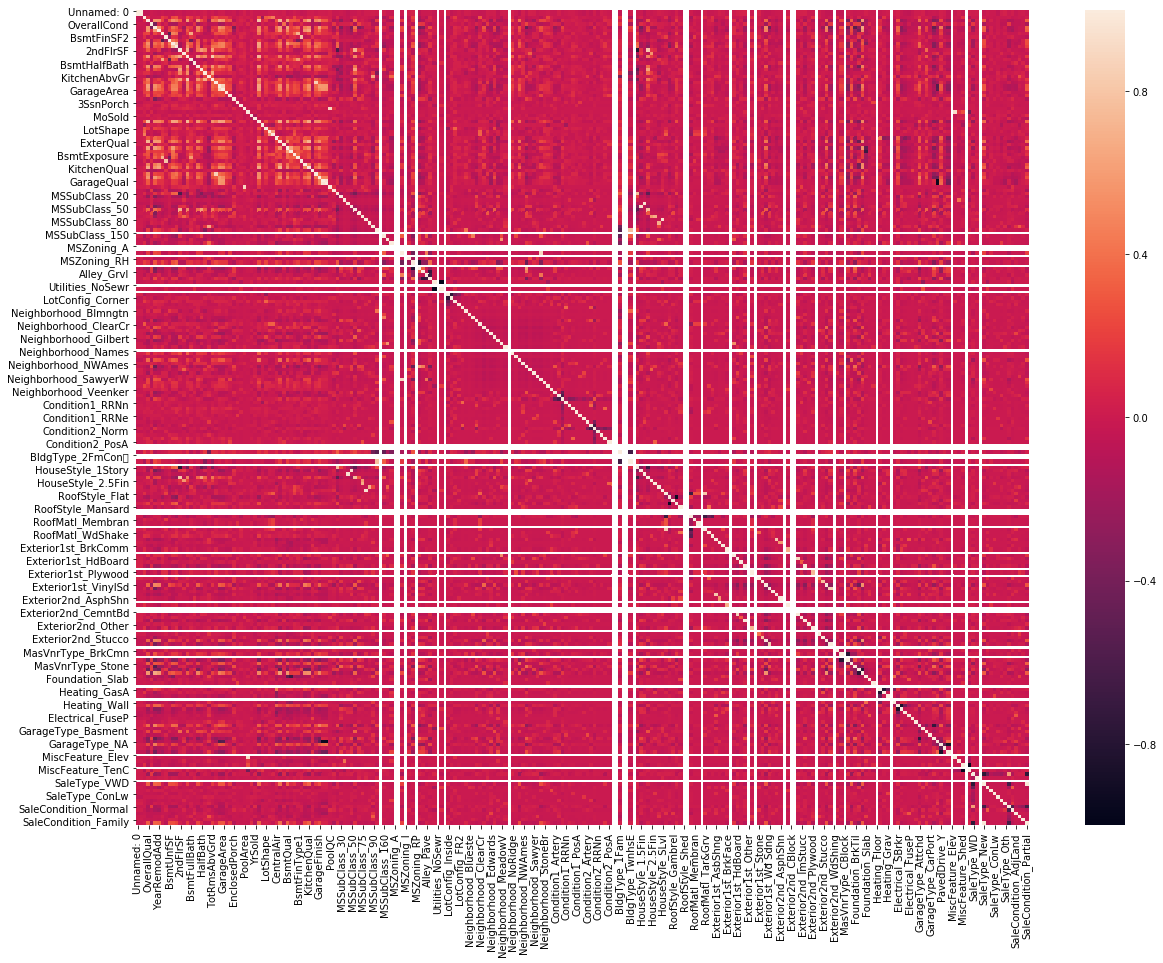

In [26]:
# Data correlation heatmaps

plt.subplots(figsize=(20,15))
sns.heatmap(all_numerical_train.corr(method="pearson"))

#plt.subplots(figsize=(20,15))
#sns.heatmap(traindataset.corr(method="spearman"))

#plt.subplots(figsize=(20,15))
#sns.heatmap(traindataset.corr(method="kendall"))


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Divide training set and use scaler

#scaler = StandardScaler().fit(allnum_train)
#scaled_X = scaler.transform(allnum_train)

realscaler = StandardScaler().fit(all_numerical_train)
realscaled_X = realscaler.transform(all_numerical_train)

seed = 9
test_size = 0.20

#X_train, X_test, Y_train, Y_test  = train_test_split(allnum_train, allnum_prices, test_size = test_size, random_state = seed)

X_train, X_test, Y_train, Y_test  = train_test_split(all_numerical_train, prices, test_size = test_size, random_state = seed)


print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(960, 250)
(240, 250)
(960,)
(240,)


GradientBoost: -22463675.384, 46034207.866
ExtraTrees: -53729736.446, 57442687.969
KNN: -37563709.798, 88844690.423
AdaBoost: -104902886.282, 65453055.092
Linear: -0.0, 0.0
RandomForest: -37616896.147, 82995414.004
ElasticNet: -0.006, 0.008
SVR: -6605797998.493, 1150777548.5
Lasso: -450601.971, 1351805.907
DecisionTree: -70859050.786, 111930040.769


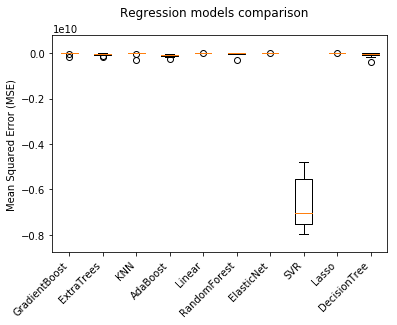

In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

# user variables to tune
folds   = 10
metric  = "neg_mean_squared_error"

# hold different regression models in a single dictionary
models = {}
models["Linear"]        = LinearRegression()
models["Lasso"]         = Lasso()
models["ElasticNet"]    = ElasticNet()
models["KNN"]           = KNeighborsRegressor()
models["DecisionTree"]  = DecisionTreeRegressor()
models["SVR"]           = SVR()
models["AdaBoost"]      = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"]  = RandomForestRegressor()
models["ExtraTrees"]    = ExtraTreesRegressor()

# 10-fold cross validation for each model
model_results = []
model_names   = []
for model_name in models:
    model   = models[model_name]
    k_fold  = KFold(n_splits=folds, random_state=seed)
    results = cross_val_score(model, X_train, Y_train, cv=k_fold, scoring=metric)
    
    model_results.append(results)
    model_names.append(model_name)
    print("{}: {}, {}".format(model_name, round(results.mean(), 3), round(results.std(), 3)))

# box-whisker plot to compare regression models
figure = plt.figure()
figure.suptitle('Regression models comparison')
axis = figure.add_subplot(111)
plt.boxplot(model_results)
axis.set_xticklabels(model_names, rotation = 45, ha="right")
axis.set_ylabel("Mean Squared Error (MSE)")
plt.margins(0.05, 0.1)
plt.show()

[INFO] MSE : 27302707.213
Score:  0.9964592119164064


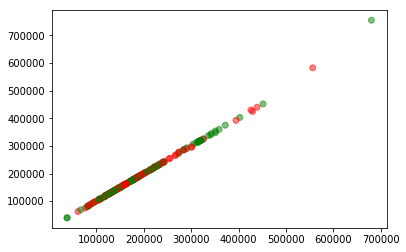

In [22]:
# Best model 
best_model = GradientBoostingRegressor(random_state=seed)
best_model.fit(X_train,Y_train)

best_predictions = best_model.predict(X_test)
print("[INFO] MSE : {}".format(round(mean_squared_error(Y_test, best_predictions), 3)))
print("Score: ", best_model.score(X_test, Y_test))

plt.scatter(best_predictions, Y_test, alpha=0.5, c=['r','g'])
plt.show()

In [23]:
# Linear regression
from sklearn.linear_model import LinearRegression
# Create linear regression object
lin_regr = LinearRegression()

# Fit the training set
lin_regr.fit(X_train, Y_train)

predictions_on_train = lin_regr.predict(X_train)
predictions_on_test = lin_regr.predict(X_test)

# plots
print("lin reg train_score: " ,lin_regr.score(X_train, Y_train))
print("lin reg test_score" ,lin_regr.score(X_test, Y_test))

'''
plt.scatter(predictions_on_train, predictions_on_train - Y_train, c='r', s=40, alpha=0.5)
plt.scatter(predictions_on_test, predictions_on_test - Y_test, c='b', s=40)
plt.hlines(y=0, xmin=0, xmax=50)
'''

lin reg train_score:  1.0
lin reg test_score 1.0


"\nplt.scatter(predictions_on_train, predictions_on_train - Y_train, c='r', s=40, alpha=0.5)\nplt.scatter(predictions_on_test, predictions_on_test - Y_test, c='b', s=40)\nplt.hlines(y=0, xmin=0, xmax=50)\n"

In [24]:
# Ridge regression
from sklearn.linear_model import Ridge

rr = Ridge(alpha = 0.01)
rr.fit(X_train, Y_train)

rr100 = Ridge(alpha=100) #  comparison with low alpha value
rr100.fit(X_train, Y_train)

print("Train Ridge_train_score0.01: ",rr.score(X_train,Y_train))
print("Test Ridge_train_score0.01: ",rr.score(X_test, Y_test))

print("Train Ridge_train_score100: ",rr100.score(X_train,Y_train))
print("Test Ridge_test_score100: ",rr100.score(X_test, Y_test))

Train Ridge_train_score0.01:  1.0
Test Ridge_train_score0.01:  1.0
Train Ridge_train_score100:  1.0
Test Ridge_test_score100:  1.0


In [25]:
# Lasso Regression for feature selection
from sklearn.linear_model import Lasso


lasso = Lasso()
lasso.fit(X_train, Y_train)
print("Train Lasso score: ",lasso.score(X_train,Y_train))
print("Test Lasso score: ",lasso.score(X_test,Y_test))
coeff_used = np.sum(lasso.coef_!=0)
print("Coefficents used: ", coeff_used)


lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train, Y_train)
print("Train Lasso001 score: ",lasso001.score(X_train,Y_train))
print("Test Lasso001 score: ",lasso001.score(X_test,Y_test))
coeff_used001 = np.sum(lasso001.coef_!=0)
print("Coefficents used: ", coeff_used001)

lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train, Y_train)
print("Train Lasso001 score: ",lasso00001.score(X_train,Y_train))
print("Test Lasso001 score: ",lasso00001.score(X_test,Y_test))
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print("Coefficents used: ", coeff_used00001)

'''print(lasso.coef_)
print(lasso001.coef_)
print(lasso00001.coef_)
'''

Train Lasso score:  0.9999999999998074
Test Lasso score:  0.9999999999997878
Coefficents used:  12
Train Lasso001 score:  0.9999999999999926
Test Lasso001 score:  0.9999999999999925
Coefficents used:  20
Train Lasso001 score:  1.0
Test Lasso001 score:  1.0
Coefficents used:  20


'print(lasso.coef_)\nprint(lasso001.coef_)\nprint(lasso00001.coef_)\n'